In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aksara-jawa-dataset/readme.md
/kaggle/input/aksara-jawa-dataset/notebook.ipynb
/kaggle/input/aksara-jawa-dataset/requirements.txt
/kaggle/input/aksara-jawa-dataset/package-lock.json
/kaggle/input/aksara-jawa-dataset/draw_test.py
/kaggle/input/aksara-jawa-dataset/upload_test.py
/kaggle/input/aksara-jawa-dataset/package.json
/kaggle/input/aksara-jawa-dataset/data-test/na/test_na2.png
/kaggle/input/aksara-jawa-dataset/data-test/na/test_na1.png
/kaggle/input/aksara-jawa-dataset/data-test/na/test_na3.png
/kaggle/input/aksara-jawa-dataset/data-test/wa/test-wa1.png
/kaggle/input/aksara-jawa-dataset/data-test/wa/test-wa3.png
/kaggle/input/aksara-jawa-dataset/data-test/wa/test-wa2.png
/kaggle/input/aksara-jawa-dataset/data-test/ra/test-ra1.png
/kaggle/input/aksara-jawa-dataset/data-test/ra/test-ra2.png
/kaggle/input/aksara-jawa-dataset/data-test/ta/test-ta2.png
/kaggle/input/aksara-jawa-dataset/data-test/ta/test-ta1.png
/kaggle/input/aksara-jawa-dataset/data-test/da/test-da2.png
/

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


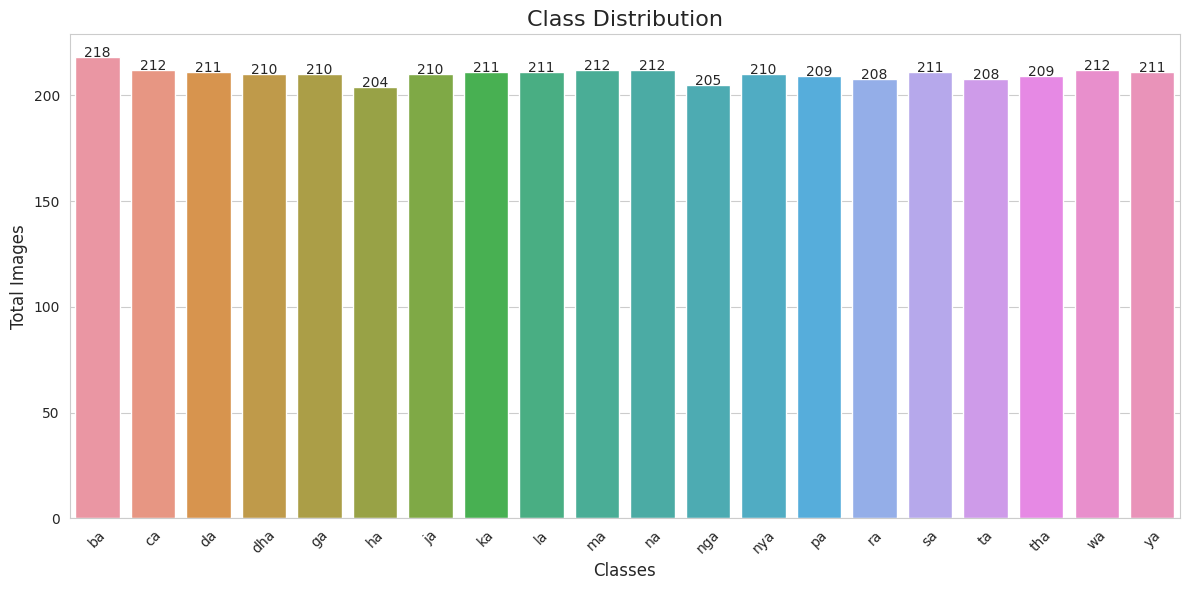

In [2]:
import glob

import matplotlib.pyplot as plt
import seaborn as sns


train_path = "/kaggle/input/aksara-jawa-dataset/data"
test_path = "/kaggle/input/aksara-jawa-dataset/data-test"
class_names = ["ba","ca","da","dha","ga","ha","ja",
               "ka","la","ma","na","nga","nya","pa",
               "ra","sa","ta","tha","wa","ya"]
class_distribution = {}

# Put image paths to dictionary using class names as keys.
for class_name in class_names:
    class_distribution[class_name] = len(glob.glob(f"{train_path}/{class_name}/*"))

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))

plt.title("Class Distribution", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Total Images", fontsize=12)
plt.xticks(rotation=45)

# Add value labels of each bar.
for index, value in enumerate(class_distribution.values()):
    plt.text(index, value, str(value), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

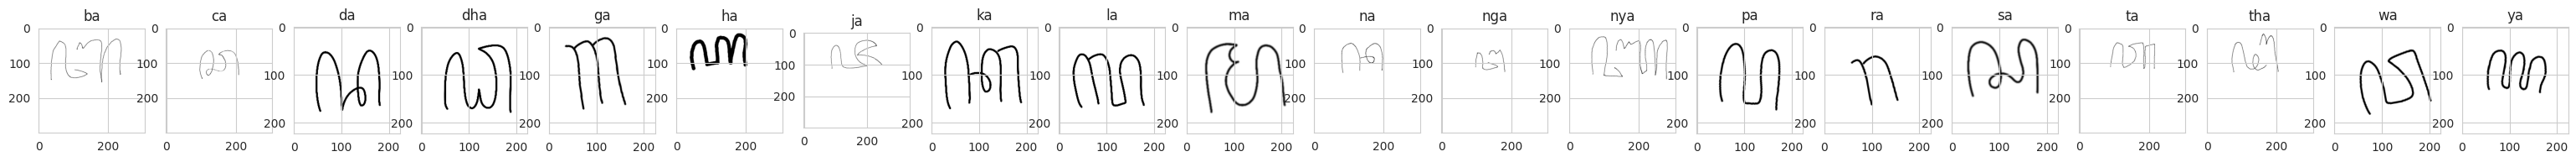

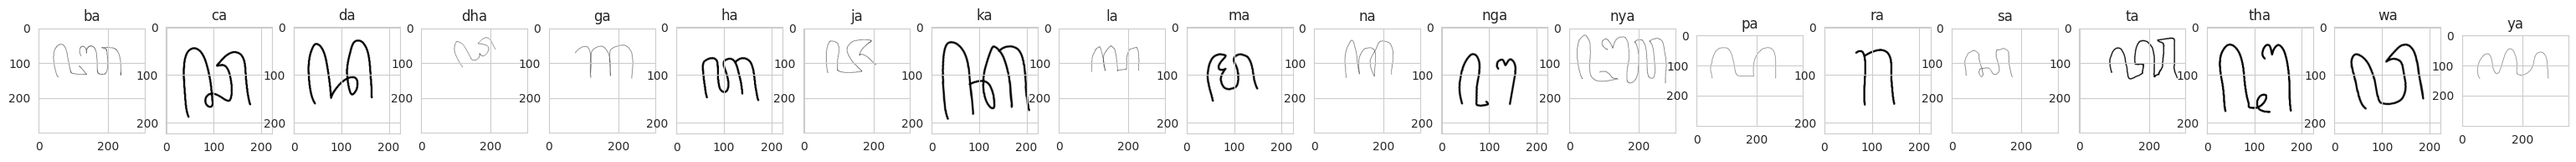

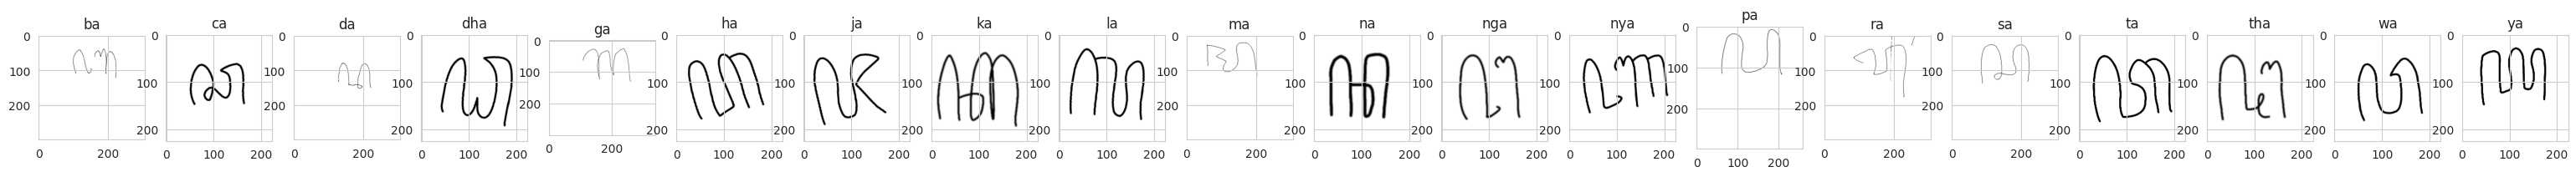

In [3]:
import cv2
import numpy as np


def plot_sample_images(class_names):
    fig, axis = plt.subplots(1, len(class_names), figsize=[39,45])

    for index, (class_name, count) in enumerate(class_distribution.items()):
        # Randomly choose images to plot.
        random_index = np.random.randint(0, count)
        img_read = cv2.imread(
            glob.glob(f"{train_path}/{class_name}/*")[random_index]
        )

        axis[index].imshow(img_read)
        axis[index].set_title(class_name)

# Plot several samples of each class.
for i in range(0, 3):
    plot_sample_images(class_names)

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input



# Data generator for traning and validation.
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2, # 20% of images to be used for validation.
    preprocessing_function=preprocess_input
    )

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    subset="training",
    shuffle=True
    )

validation_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    subset="validation",
    shuffle=False
)
     

Found 3369 images belonging to 20 classes.
Found 834 images belonging to 20 classes.


In [5]:
# Data generator for evaluation.
test_data_generator = ImageDataGenerator(rescale=1./255,
                                         preprocessing_function=preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle = False  # Keep this False for confusion matrix.
)
   

Found 55 images belonging to 20 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Create enhanced model with Inception v2
def create_model(num_classes):
    base_model = InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )

    # Freeze only the first few layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    # Add custom layers with stronger regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First dense block
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.4)(x)

    # Second dense block
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

def visualize_model_architecture(model):
    """
    Visualize the model architecture using plot_model
    """
    # Create the model flowchart
    plot_model(
        model,
        to_file='cnn_model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='LR'
    )

    # Display the flowchart
    plt.figure(figsize=(15, 10))
    img = plt.imread('cnn_model.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Model Architecture')
    plt.show()

In [7]:
def create_callbacks():
    """
    Create enhanced callbacks for better training
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,              # Increased patience
        restore_best_weights=True,
        min_delta=0.001          # Minimum change to qualify as an improvement
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,              # More aggressive LR reduction
        patience=8,              # Reduced patience for LR reduction
        min_lr=1e-8,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    return early_stopping, reduce_lr, checkpoint

def train_model(model, train_generator, validation_generator):
    early_stopping, reduce_lr, checkpoint = create_callbacks()

    # Use a learning rate schedule
    initial_learning_rate = 1e-5

    f1 = tf.keras.metrics.F1Score(average='macro', threshold=0.5)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', f1]
    )

    # Train with class weights if dataset is imbalanced
    history = model.fit(
        train_generator,
        epochs=100,  # Increased epochs since we have better regularization
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint],
    )

    return history

In [8]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

In [9]:
def main(train_generator, validation_generator):
    # Create data generators
    train_generator, validation_generator = train_generator, validation_generator

    # Create model
    num_classes = len(train_generator.class_indices)
    model, base_model = create_model(num_classes)

    # Initial training with frozen base layers
    history = train_model(model, train_generator, validation_generator)
    plot_training_history(history)

    return model, base_model

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732263956.007392     123 service.cc:145] XLA service 0x7a6c4c001dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732263956.007449     123 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732263956.007454     123 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732264048.019823     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_159', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers 

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0467 - f1_score: 0.0045 - loss: 4.6468
Epoch 1: val_accuracy improved from -inf to 0.04916, saving model to best_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.0468 - f1_score: 0.0045 - loss: 4.6463 - val_accuracy: 0.0492 - val_f1_score: 0.0000e+00 - val_loss: 4.5629 - learning_rate: 1.0000e-05
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.0719 - f1_score: 0.0034 - loss: 4.5369
Epoch 2: val_accuracy did not improve from 0.04916
106/106 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.0718 - f1_score: 0.0034 - loss: 4.5366 - val_accuracy: 0.0492 - val_f1_score: 0.0000e+00 - val_loss: 8.3378 - learning_rate: 1.0000e-05
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.0872 - f1_score: 0.0072 - loss: 4.4071
Epoch 3: val_accuracy improved from 0.04916 to 0.05276, saving model to best_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.0872 - f1_score: 0.0072 -

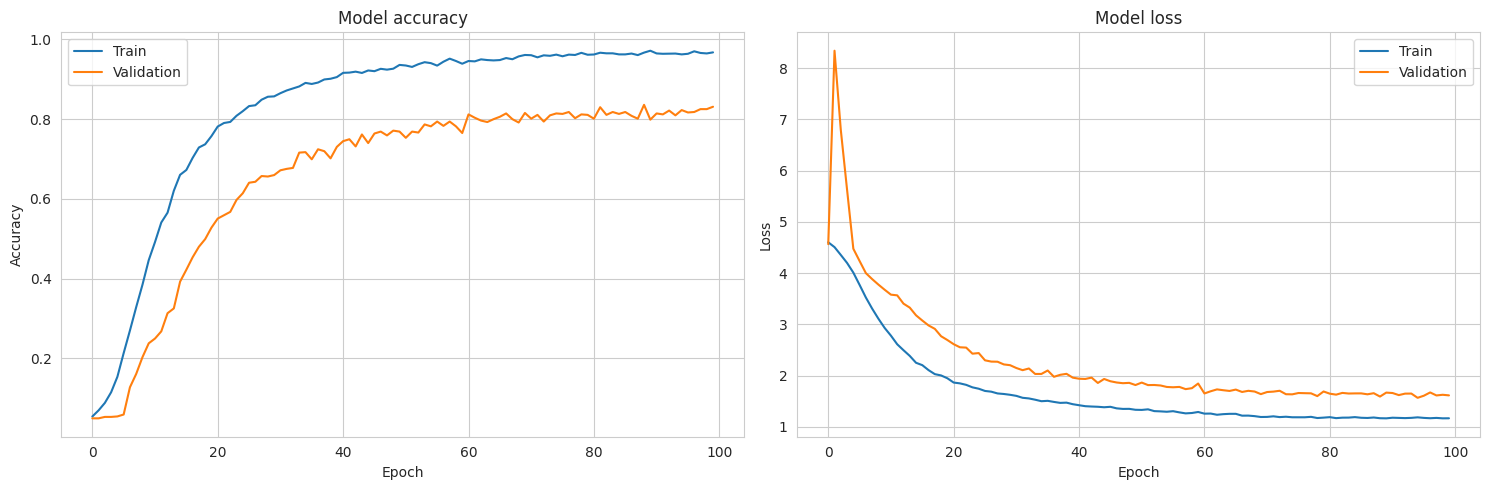

In [10]:

if __name__ == "__main__":
    model, base_model = main(train_generator, validation_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 20s/step
Classification Report (Testing Data):

              precision    recall  f1-score   support

          ba       1.00      1.00      1.00         2
          ca       1.00      1.00      1.00         4
          da       0.00      0.00      0.00         2
         dha       1.00      1.00      1.00         3
          ga       0.67      0.67      0.67         3
          ha       0.44      0.80      0.57         5
          ja       1.00      1.00      1.00         3
          ka       1.00      1.00      1.00         2
          la       0.00      0.00      0.00         3
          ma       1.00      1.00      1.00         3
          na       1.00      1.00      1.00         3
         nga       1.00      1.00      1.00         2
         nya       1.00      1.00      1.00         2
          pa       1.00      1.00      1.00         2
          ra       1.00      1.00      1.00         2
          sa       0.50      0.67      0.57         3
    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


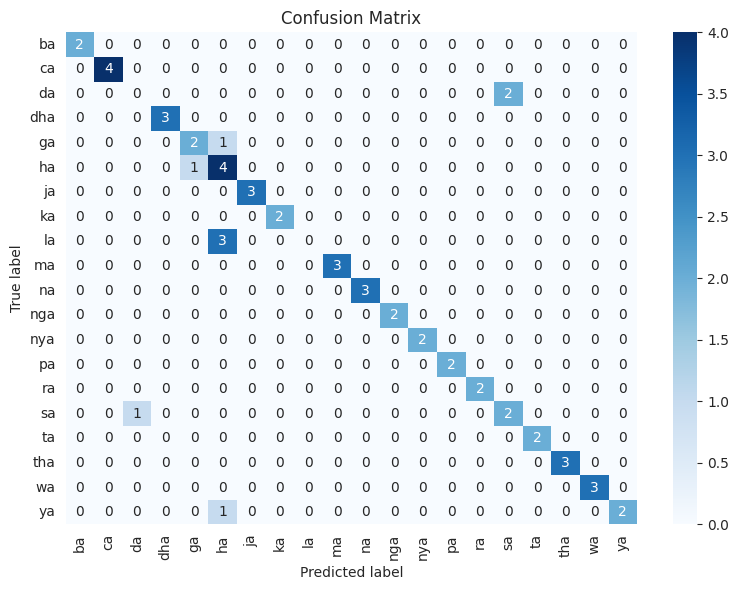

In [11]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


# Nama-nama kelas emosi
class_names = ["ba","ca","da","dha","ga","ha","ja",
               "ka","la","ma","na","nga","nya","pa",
               "ra","sa","ta","tha","wa","ya"]

# Peroleh true labels dari test generator
true_labels = test_generator.classes

# Reset test generator sebelum prediksi
test_generator.reset()

# Dapatkan prediksi model pada data test
predicted = model.predict(test_generator)
predicted_labels = np.argmax(predicted, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
result_testing = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report (Testing Data):\n")
print(result_testing)

# Menghitung Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy Testing: {accuracy:.4f}")

# Menghitung F1-Score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1-Score Testing: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()